### Emotional Lexicons
Emotional lexicons differ from the Opinion Lexicons because they express more than just positive and negative emotions. They also aknowledge emotional states associated with the author present state when writing the text like angry, happiness, etc.

In [ ]:
%matplotlib inline
import libs.files as fh
import libs.parse as p
import libs.pipeline as pipe
import libs.utils as u
import numpy as np
import matplotlib.pyplot as plt
# from sklearn.feature_extraction import DictVectorizer
import nltk
# from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import scipy as scy
from sklearn import model_selection
# import cPickle
import libs.resources as r

import pandas as pd

from IPython.display import display

plt.style.use('seaborn-muted')

In [ ]:
# read the information
OUTPUT_DIR = '../3-Output/'
MODEL_OUT_DIR = '../6-Models'
CREATE_TOKENS_FILES = True
PROCESS_DIR = '../2-Processed'

# read the config file
cfg = fh.read_config_file("all.yaml")

# read the train file
file_name = "../1-Input/trainingData-B.tsv"
file_type = 'B'
train_feat, labels, train_tweets = pipe.create_features(file_name, file_type, cfg)

# read the dev file
file_name = "../1-Input/devData-B.tsv"
file_type = 'B'
dev_feat, dev_labels, dev_tweets = pipe.create_features(file_name, file_type, cfg)

# read the test file
file_name = "../1-Input/testData-B.tsv"
file_type = 'B'
test_feat, gold, test_tweets = pipe.create_features(file_name, file_type, cfg)

In [ ]:
# random seed for all the operations
rnd_seed = 9000

# convert the list into and array that can be indexed
labels = np.array(labels)
dev_labels = np.array(dev_labels)
gold = np.array(gold)

# create the cleaned the tweets
train_clean, dev_clean, vect = pipe.create_count_vec(train_tweets, dev_tweets, tokenizer=pipe.tokenize_clean_raw, stop_words=pipe.stop_words)
train_data, dev_data, selec = pipe.auto_select_features(pipe.chi2, 5, train_clean, labels, dev_clean, dev_labels)

In [ ]:
# not using negated tokens
train_tokens = [pipe.tokenize_clean_raw(t) for t in train_tweets]
dev_tokens = [pipe.tokenize_clean_raw(t) for t in dev_tweets]
test_tokens = [pipe.tokenize_clean_raw(t) for t in test_tweets]

In [ ]:
# using negated tokens
train_neg_tokens = [pipe.tokenize_negate_clean_raw(t) for t in train_tweets]
dev_neg_tokens = [pipe.tokenize_negate_clean_raw(t) for t in dev_tweets]
test_neg_tokens = [pipe.tokenize_negate_clean_raw(t) for t in test_tweets]

In [ ]:
base_scores = pipe.run_multiple_class(train_data, labels, dev_data, dev_labels, rnd_seed=rnd_seed)
pipe.pprint_results(base_scores)

In [68]:
# this needs to be run only for ANEW
def run_lex_test(lex, verbose=True, select=False, percent=5, negate=False, use_best_params=True, **params):
    # create lexicon features
    if negate:
        train_sent = lex.process_lex(train_neg_tokens, **params)
        dev_sent = lex.process_lex(dev_neg_tokens, **params)
    else:
        train_sent = lex.process_lex(train_tokens, **params)
        dev_sent = lex.process_lex(dev_tokens, **params)
    
    if verbose:
        print train_sent[:3]
        
        # print coverage
        num_tw_found_train = float(np.array([ 1 for t in train_sent if t]).sum())
        num_tw_found_dev = float(np.array([ 1 for t in dev_sent if t]).sum())
        len_train = len(train_sent)
        len_dev = len(dev_sent)
        per_train = num_tw_found_train/len_train
        per_dev = num_tw_found_dev/len_dev
        print('num_tw_found_train, len_train, num_tw_found_dev, len_dev',num_tw_found_train, len_train, num_tw_found_dev, len_dev)
        print('Coverage train: {0:.2%}, test: {0:.2%}'.format(per_train, per_dev))

    # select the feature if needed
    create_vec=True
    if select:
        train_sent, dev_sent, _, vect = pipe.create_lex_vec(train_sent, dev_sent)
#         if verbose == True:
#             print vect.get_feature_names()[:3]
#             print train_sent[0]
        train_sent, dev_sent, _ = pipe.auto_select_features(pipe.mutual_info_classif, percent, 
                                                            train_sent, labels, 
                                                            dev_sent, dev_labels)
        create_vec = False
    
    # create training and dev datasets
    X ,X_dev = pipe.join_lex_features(train_data, train_sent,
                                      dev_data, dev_sent,
                                      create_vec=create_vec)


    # train the algorithms
    ret = pipe.run_multiple_class(X, labels, X_dev, dev_labels, rnd_seed=rnd_seed, use_best_params=use_best_params)
    return ret

In [69]:
def test_percentile(lex, percentile, test_name, negate=False, **features):
    tmp = run_lex_test(lex, select=True, percent=percentile, negate=negate, **features)
    tmp = tmp[['train score', '{} score'.format(test_name)]]
    return tmp.add_prefix(str(percentile)+' ')

    
def compare_percentiles(lex, percentiles = [5,10,15,30, 100], test_name='dev', negate=False, **features):
    
    def highlight_max(s):
        '''
        highlight the maximum in a Series in bold.
        '''
        is_max = s == s.max()
        css = ['font-weight: bold' if v else '' for v in is_max]
        return css
    
    def highlight_top3(s):
        '''
        highlight the top3 in a Series in bold.
        '''
        # colors for the background an create an ordered vector
        shades = [200, 220, 247]
        ordered = s.sort_values(ascending=False)
        ordered.reset_index(inplace=True, drop=True)
        idx = pd.Index(ordered)
        
        # paint the Background accordingly
        css = ['background-color: rgb({color},{color},{color})'\
               .format(color=shades[idx.get_loc(v)]) \
               if idx.get_loc(v)<3 else '' for v in s]
        return css

    
    # get a first df
    df = test_percentile(lex, percentiles[0], test_name, negate=negate, **features)
    for perc in percentiles[1:]:
        tmp = test_percentile(lex, perc, test_name, negate=negate, **features)
        df = pd.concat([df, tmp], axis = 1)

    return df.style.apply(highlight_max).apply(highlight_top3)

In [70]:
def process_emo_pipeline(lex, train_tokens, dev_tokens, 
                         train_data, labels, dev_data, dev_labels, 
                         select_features=False, select_percent=5,
                         verbose=False, 
                         **params):
    """"
    Process a emotional pipeline creating emotional tokens, joining with regular tokens and training/testing
    on the classifiers
    """
    # create emotional info
    train_sent = lex.process_lex(train_tokens, **params)
    dev_sent = lex.process_lex(dev_tokens, **params)
    
    if verbose:
        print train_sent[:3]
    
    # if should select features
    create_vec = True
    if select_features:
        train_sent, dev_sent, _, vect = pipe.create_lex_vec(train_sent, dev_sent)
#         if verbose == True:
#             print vect.get_feature_names()[:3]
#             print train_sent[0]
        train_sent, dev_sent, _ = pipe.auto_select_features(pipe.mutual_info_classif, select_percent, 
                                                            train_sent, labels, 
                                                            dev_sent, dev_labels)
        create_vec = False
        
    if verbose:
        if create_vec:
            # not a vector, just check if thre is a dictionary with the features
            num_tw_found_train = float(np.array([ 1 for t in train_sent if t]).sum())
            num_tw_found_dev = float(np.array([ 1 for t in dev_sent if t]).sum())
        else:
            # it is an vector. For each tweet sum the number of tokens found
            train_tmp = train_sent.todense()
            dev_tmp = dev_sent.todense()
            num_tw_found_train = float(np.array([ 1 for t in train_tmp if t.sum()]).sum())
            num_tw_found_dev = float(np.array([ 1 for t in dev_tmp if t.sum()]).sum())
        
        len_train = len(train_tokens)
        len_dev = len(dev_tokens)
        per_train = num_tw_found_train/len_train
        per_dev = num_tw_found_dev/len_dev
        print('num_tw_found_train, len_train, num_tw_found_dev, len_dev',num_tw_found_train, len_train, num_tw_found_dev, len_dev)
        print('Coverage train: {0:.2%}, test: {0:.2%}'.format(per_train, per_dev))
        
    # create training and dev datasets
    try:
        X ,X_dev = pipe.join_lex_features(train_data, train_sent,
                                      dev_data, dev_sent,
                                      create_vec=create_vec)
    
        # run the classifiers
        scores = pipe.run_multiple_class(X, labels, 
                                     X_dev, dev_labels, 
                                     rnd_seed=rnd_seed, scale=False)
        return scores, train_sent, dev_sent  
    except:
        return pipe.create_dummy_scores_df(), train_sent, dev_sent  

In [71]:
def test_percentile(lex, percentile, test_name, verbose=False, **features):
    tmp, _, _ = process_emo_pipeline(lex, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels, 
                     select_features=True, select_percent=percentile,
                     **features)
    tmp = tmp[['train score', '{} score'.format(test_name)]]
    return tmp.add_prefix(str(percentile)+' ')

def print_emo_percent_model(lex, percentile, verbose=True, **features):
    """
    Print the results table of an emotional pipeline with feature selection
    """
    tmp, train, dev= process_emo_pipeline(lex, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels, 
                     select_features=True, select_percent=percentile, verbose=verbose,
                     **features)
    return pipe.pprint_results(tmp)
   
def compare_percentiles(lex, percentiles = [5,10,15,30, 100], test_name='dev', verbose=False, negate=False, **features):
    
    def highlight_max(s):
        '''
        highlight the maximum in a Series in bold.
        '''
        is_max = s == s.max()
        css = ['font-weight: bold' if v else '' for v in is_max]
        return css
    
    def highlight_top3(s):
        '''
        highlight the top3 in a Series in bold.
        '''
        # colors for the background an create an ordered vector
        shades = [200, 220, 247]
        ordered = s.sort_values(ascending=False)
        ordered.reset_index(inplace=True, drop=True)
        idx = pd.Index(ordered)
        
        # paint the Background accordingly
        css = ['background-color: rgb({color},{color},{color})'\
               .format(color=shades[idx.get_loc(v)]) \
               if idx.get_loc(v)<3 else '' for v in s]
        return css
    
    # get a first df
    df = test_percentile(lex, percentiles[0], test_name, **features)
    for perc in percentiles[1:]:
        tmp = test_percentile(lex, perc, test_name, **features)
        df = pd.concat([df, tmp], axis = 1)

    return df.style.apply(highlight_max).apply(highlight_top3)

def test_individual_scales(lex, verbose=True, **features):
    columns = [ col[len(lex.prefix)+1:] for col in lex.df.columns]
    print columns
    for col in columns:
        print(col)

        # no tokens, just the statistics
        features['filter_tags'] = [col]
        
        tmp, train, dev= process_emo_pipeline(lex, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels, 
                     verbose=verbose,
                     **features)
        display(pipe.pprint_results(tmp))

### ANEW
ANEW lexicon is based on the Semantic Differential Scale and present a list of word with 3 values representing dominance, arousal and valence. Using this 3 different values, sentiments like anger, happiness , etc could be represented. **ONLY THE VALENCE SCORE WAS USED**

In [ ]:
print(r.anew.df.shape)
r.anew.df.head(10)

In [ ]:
a = r.anew.df.hist(bins=20, grid=False)[0][0]
a.set_title('Anew Values')
a.set_xlabel('Values')
_ = a.set_ylabel('Count of Values')

Testing all parameters, but not tokens

In [ ]:
lex_features = {
    'return_tokens':False,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}
ret_anew = run_lex_test(r.anew, verbose=True, **lex_features)
pipe.pprint_results(ret_anew)

In [ ]:
ret_anew = run_lex_test(r.anew, verbose=True, negate=True, **lex_features)
pipe.pprint_results(ret_anew)

In [72]:
lex_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True
}
ret_anew = compare_percentiles(r.anew, verbose=False, **lex_features)
ret_anew

Final shape (8171, 31) (1405, 31)
train data, lex and final shape:  (8171, 927) (8171, 31) (8171, 958)
test data, lex and final shape:  (1405, 927) (1405, 31) (1405, 958)
Final shape (8171, 61) (1405, 61)
train data, lex and final shape:  (8171, 927) (8171, 61) (8171, 988)
test data, lex and final shape:  (1405, 927) (1405, 61) (1405, 988)
Final shape (8171, 90) (1405, 90)
train data, lex and final shape:  (8171, 927) (8171, 90) (8171, 1017)
test data, lex and final shape:  (1405, 927) (1405, 90) (1405, 1017)
Final shape (8171, 181) (1405, 181)
train data, lex and final shape:  (8171, 927) (8171, 181) (8171, 1108)
test data, lex and final shape:  (1405, 927) (1405, 181) (1405, 1108)
Final shape (8171, 605) (1405, 605)
train data, lex and final shape:  (8171, 927) (8171, 605) (8171, 1532)
test data, lex and final shape:  (1405, 927) (1405, 605) (1405, 1532)


### Best Model Anew

In [52]:
lex_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True
}
ret_anew = run_lex_test(r.anew, select=True, percent=30, verbose=True, **lex_features)
pipe.pprint_results(ret_anew)

[{u'ANEW_house': 7.23, 'ANEW_avg': 5.25, 'ANEW_posamt': 2, 'ANEW_min': 3.27, 'ANEW_negamt': 0, 'ANEW_sum': 10.5, u'ANEW_hit': 3.27, 'ANEW_max': 7.2300000000000004}, {'ANEW_avg': 6.04, u'ANEW_watch': 6.04, 'ANEW_posamt': 1, 'ANEW_min': 6.04, 'ANEW_negamt': 0, 'ANEW_sum': 6.04, 'ANEW_max': 6.04}, {'ANEW_avg': 1.79, 'ANEW_posamt': 1, 'ANEW_min': 1.79, 'ANEW_negamt': 0, 'ANEW_sum': 1.79, u'ANEW_hate': 1.79, 'ANEW_max': 1.79}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8171.0, 8171, 1405.0, 1405)
Coverage train: 100.00%, test: 100.00%
Final shape (8171, 181) (1405, 181)
train data, lex and final shape:  (8171, 927) (8171, 181) (8171, 1108)
test data, lex and final shape:  (1405, 927) (1405, 181) (1405, 1108)


In [73]:
lex_features = {
    'return_tokens':True,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True
}
ret_anew = compare_percentiles(r.anew, verbose=False, negate=True, **lex_features)
ret_anew

Final shape (8171, 31) (1405, 31)
train data, lex and final shape:  (8171, 927) (8171, 31) (8171, 958)
test data, lex and final shape:  (1405, 927) (1405, 31) (1405, 958)
Final shape (8171, 61) (1405, 61)
train data, lex and final shape:  (8171, 927) (8171, 61) (8171, 988)
test data, lex and final shape:  (1405, 927) (1405, 61) (1405, 988)
Final shape (8171, 90) (1405, 90)
train data, lex and final shape:  (8171, 927) (8171, 90) (8171, 1017)
test data, lex and final shape:  (1405, 927) (1405, 90) (1405, 1017)
Final shape (8171, 181) (1405, 181)
train data, lex and final shape:  (8171, 927) (8171, 181) (8171, 1108)
test data, lex and final shape:  (1405, 927) (1405, 181) (1405, 1108)
Final shape (8171, 605) (1405, 605)
train data, lex and final shape:  (8171, 927) (8171, 605) (8171, 1532)
test data, lex and final shape:  (1405, 927) (1405, 605) (1405, 1532)


In [ ]:
train_sent = r.anew.process_lex(train_tokens, **lex_features)
dev_sent = r.anew.process_lex(dev_tokens, **lex_features)

# select the feature if needed
train_sent2, dev_sent2, _, vect = pipe.create_lex_vec(train_sent, dev_sent)
train_sent1, dev_sent1, sel = pipe.auto_select_features(pipe.mutual_info_classif, 5, 
                                                    train_sent2, labels, 
                                                    dev_sent2, dev_labels)

In [ ]:
vect.get_feature_names()[sel.scores_.argmax()]
sel.scores_.argmax()

In [ ]:
get_most_important_feat(sel, vect)

In [ ]:
lex_features = {
    'return_tokens':False,
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'final_pol':True
}

# test all the keys, one by one
for key in lex_features.keys():
    print('Testing key {}'.format(key))
    tmp = {key:True}
    ret_anew = run_lex_test(r.anew, verbose=True, negate=True, **tmp)
    display(pipe.pprint_results(ret_anew))

** Conclusion:** As this is a very small lexicon, the results did not affect the final prediction much

### Wordnet Affect

In [ ]:
r.wna.df.sample(10)

In [ ]:
print r.wna.df.shape

fig, axs = plt.subplots(1,2, figsize = (15,5))

a = r.wna.df.sum(axis=0)
a = a.sort_values(ascending=False).hist(grid=False, bins=100, ax = axs[0])
a.set_title('Labels use')
a.set_xlabel('Number of Tokens where label is present')
_ = a.set_ylabel('Labels Amount')

a = r.wna.df.sum(axis=1)
a = a.sort_values(ascending=False).hist(grid=False, bins=100)
a.set_title('Labels per Token')
a.set_xlabel('Number of labels in the token')
_ = a.set_ylabel('Number of Tokens')

In [ ]:
b = r.wna.df
d = {}
for i, row in enumerate(b.iteritems()):
    for tag, val in row[1].iteritems():
        s = d.get(tag, '')
        s = s + ('1' if val==1.0 else '0')
        d[tag] = s
items = [ k for k,v in d.iteritems() ]
vals =  [ v for k,v in d.iteritems() ]
wna_df_count = pd.DataFrame(data = items, index = vals, columns = ['word'])
b = wna_df_count.groupby(wna_df_count.index)['word'].count().sort_values(ascending=False)
print b.shape
for i in range(30):
    print list(r.wna.df.columns[[n=='1' for n in b.index[i]]])

In [ ]:
wna_params = dict(return_tokens=True, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=False)

In [ ]:
train_sent_wna = process_emo_lex(r.wna, train_tokens, bigrams=True, trigrams=True, join_char=' ', **wna_params)
dev_sent_wna = process_emo_lex(r.wna, dev_tokens, bigrams=True, trigrams=True, join_char=' ', **wna_params)

In [ ]:
train_sent_wna[4]

As the emotional lexicons may have more than one sentiment associated to a token, we need to convert them to single dictionary with the sentiments for each word. This will exponentiate the number of features

In [ ]:
X_wna,X_dev_wna = pipe.join_lex_features(train_data, train_sent_wna,
                                          dev_data, dev_sent_wna)

In [ ]:
# version using the tokens
ret_wna = pipe.run_multiple_class(X_wna, labels, X_dev_wna, dev_labels, rnd_seed=rnd_seed, scale=False) 

In [ ]:
pipe.pprint_results(ret_wna)

In [ ]:
# full tokens with features selections
wna_params = dict(return_tokens=True, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True)

wna_comp = compare_percentiles(r.wna, **wna_params)
wna_comp

### Best Model WNA

In [53]:
wna_params = dict(return_tokens=True, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True)

ret,_,_ = process_emo_pipeline(r.wna, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels, 
                     select_features=True, select_percent=5, verbose=True,
                     **wna_params)
pipe.pprint_results(ret)

[{}, {u'mental-state_minn': 1, u'mental-state_avg': 1.0, u'mental-state_maxn': 1, u'tranquillity_maxn': 1, u'positive-emotion_maxn': 1, u'mental-state_count': 1, u'WNA_still_positive-emotion': 1, u'tranquillity_summ': 1, u'positive-emotion_minn': 1, u'affective-state_minn': 1, u'emotion_avg': 1.0, u'emotion_summ': 1, u'emotion_minn': 1, u'emotion_maxn': 1, u'positive-emotion_count': 1, u'calmness_count': 1, u'tranquillity_avg': 1.0, u'calmness_minn': 1, u'tranquillity_count': 1, u'WNA_still_emotion': 1, u'WNA_still_mental-state': 1, u'WNA_still_affective-state': 1, u'calmness_summ': 1, u'positive-emotion_summ': 1, u'affective-state_count': 1, u'calmness_maxn': 1, u'WNA_still_calmness': 1, u'calmness_avg': 1.0, u'positive-emotion_avg': 1.0, u'WNA_still_tranquillity': 1, u'emotion_count': 1, u'affective-state_summ': 1, u'mental-state_summ': 1, u'affective-state_avg': 1.0, u'tranquillity_minn': 1, u'affective-state_maxn': 1}, {u'WNA_hate_general-dislike': 1, u'general-dislike_maxn': 1, u'

In [ ]:
# no tokens
wna_params = dict(return_tokens=False, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True, bigrams=True, trigrams=True, join_char=' ')

# version using only the totals
scores,a,b = process_emo_pipeline(r.wna, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels, verbose=True,
                     **wna_params)
pipe.pprint_results(scores)

In [ ]:
wna_params = dict(return_tokens=False, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=False, filter_tags = ['negative-emotion', 'positive-emotion'])
train_sent_wna = process_emo_lex(r.wna, train_tokens, bigrams=True, trigrams=True, join_char=' ', **wna_params)
dev_sent_wna = process_emo_lex(r.wna, dev_tokens, bigrams=True, trigrams=True, join_char=' ', **wna_params)

X_wna,X_dev_wna = pipe.join_lex_features(train_data, train_sent_wna,
                                          dev_data, dev_sent_wna)
ret_wna = pipe.run_multiple_class(X_wna, labels, X_dev_wna, dev_labels, rnd_seed=rnd_seed, scale=False) 
pipe.pprint_results(ret_wna)


** Conclusion **: The best approach is to use the statistics of the features created.

### DAL
Dal, like Anew, uses a scale of 3 parameters to define the sentiments. Pleasantness, activation and imagery are used in here.

In [ ]:
print(r.dal.df.shape)
r.dal.df.sample(10)

In [ ]:
f, axs = plt.subplots(1,3, figsize=(15, 5), sharey=True)
a = r.dal.df.hist(grid=False,ax=axs)
axs[0].set_ylabel('Token Amount')
for ax in axs: 
    ax.set_xlabel('Scale values')
    

In [ ]:
dal_params = dict(return_tokens=True, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True)

In [ ]:
# test full features
dal_comp = compare_percentiles(r.dal, verbose=True, **dal_params)
dal_comp

In [ ]:
# no tokens, just the statistics
dal_params = dict(return_tokens=False, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True,
              bigrams=True, trigrams=True)
# test full features
scores, train_sent, test_sent = process_emo_pipeline(r.dal, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels, 
                     **dal_params)
pipe.pprint_results(scores)

In [ ]:
columns = ['activation', 'imagery', 'pleasantness']

for col in columns:
    print(col)

    # no tokens, just the statistics
    dal_params = dict(return_tokens=False, return_avg=True, 
                  return_sum=True, return_min=True, return_max=True,
                  return_pol_amt=True, filter_tags=[col])
    
    # test full features
    scores, train_sent, test_sent = process_emo_pipeline(r.dal, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels, verbose=True,
                     **dal_params)
    display(pipe.pprint_results(scores))

### Best Model DAL

In [54]:
# no tokens, just the statistics
dal_params = dict(return_tokens=False, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True,
              bigrams=True, trigrams=True)

# test full features
scores, train_sent, test_sent = process_emo_pipeline(r.dal, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels, filter_tags=['pleasantness'],
                     **dal_params)
display(pipe.pprint_results(scores))

train data, lex and final shape:  (8171, 927) (8171, 5) (8171, 932)
test data, lex and final shape:  (1405, 927) (1405, 5) (1405, 932)


In [ ]:
lex_features = {
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True
}

# test all the keys, one by one
for key in lex_features.keys():
    print('Testing key {}'.format(key))
    tmp = {key:True}
    
    # test full features
    scores, train_sent, test_sent = process_emo_pipeline(r.dal, train_tokens, dev_tokens, 
                         train_data, labels, dev_data, dev_labels,  filter_tags=['pleasantness'],
                         **tmp)
    display(pipe.pprint_results(scores))

** Conclusion **: DAL is better used with only the features count

### SenticNet

In [ ]:
print(r.sentn.df.shape)
r.sentn.df.head(10)

In [ ]:
f, axs = plt.subplots(2,2, figsize=(15, 10), sharey=True)
a = r.sentn.df.hist(grid=False,ax=axs)
axs[0][0].set_ylabel('Token Amount')
axs[1][0].set_ylabel('Token Amount')
for ax in axs: 
    ax[0].set_xlabel('Scale values')
    ax[1].set_xlabel('Scale values')
f.tight_layout()


In [ ]:
# use all tokens
sentn_params = dict(return_tokens=True, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True,
              bigrams=True, trigrams=True, join_char=' ')

# test full features
sentn_comp = compare_percentiles(r.sentn, **sentn_params)
sentn_comp

### Best Model SenticNet

In [55]:
# use all tokens
sentn_params = dict(return_tokens=True, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True,
              bigrams=True, trigrams=True, join_char=' ')
print_emo_percent_model(r.sentn, percentile=15, **sentn_params)

[{u'polarity_minn': -0.72299999999999998, u'SENTN_chapel_aptitude': 0.212, u'SENTN_hill_pleasantness': 0.0, u'attention_summ': 0.38899999999999996, u'SENTN_going_pleasantness': -0.666, u'pleasantness_maxn': 0.041000000000000002, u'aptitude_maxn': 0.21199999999999999, u'SENTN_house_aptitude': 0.0, u'aptitude_minn': -0.91700000000000004, u'SENTN_hit_polarity': -0.028, u'SENTN_going_aptitude': -0.917, u'SENTN_hit_aptitude': -0.054, u'SENTN_going_polarity': -0.723, u'attention_avg': 0.064833333333333326, u'pleasantness_minn': -0.66600000000000004, u'SENTN_chapel_polarity': 0.141, u'SENTN_hill_polarity': 0.057, u'pleasantness_avg': -0.11433333333333334, u'polarity_count': 6, u'SENTN_gas_polarity': -0.024, u'SENTN_hit_pleasantness': -0.086, u'attention_maxn': 0.23599999999999999, u'polarity_summ': -0.54600000000000004, u'aptitude_count': 6, u'SENTN_chapel_attention': 0.236, u'attention_minn': -0.057000000000000002, u'polarity_avg': -0.091000000000000011, u'SENTN_hill_aptitude': 0.078, u'SENT

In [ ]:
# no tokens
sentn_params = dict(return_tokens=False, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True,
              bigrams=True, trigrams=True, join_char=' ')
train_sent = r.process_emo_lex(r.sentn, train_tokens, **sentn_params)
train_sent[1]

In [ ]:
# no tokens
sentn_params = dict(return_tokens=False, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True,
              bigrams=True, trigrams=True, join_char=' ')
# test full features
scores, _, _ = process_emo_pipeline(r.sentn, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels, 
                     **sentn_params)
pipe.pprint_results(scores)

In [ ]:
test_individual_scales(r.sentn)

In [ ]:
lex_features = {
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True
}

# test all the keys, one by one
for key in lex_features.keys():
    print('Testing key {}'.format(key))
    tmp = {key:True}
    
    # test full features
    scores, train_sent, test_sent = process_emo_pipeline(r.sentn, train_tokens, dev_tokens, 
                         train_data, labels, dev_data, dev_labels, 
                         **tmp)
    display(pipe.pprint_results(scores))

### Emolex

In [ ]:
print(r.emlx.df.shape)
r.emlx.df.sample(30)

In [ ]:
a = r.emlx.df.sum().plot(kind='bar')
a.set_title('Nr of tokens per category')
a.set_ylabel('Nr of tokes')
_ = a.set_xlabel('Category')

In [ ]:
# use all tokens
emlx_params = dict(return_tokens=True, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True)

# test full features
emlx_comp = compare_percentiles(r.emlx, **emlx_params)
emlx_comp

### Best Model EmoLex

In [56]:
# don't use tokens
emlx_params = dict(return_tokens=False, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True)

# test full features
scores, train_sent, test_sent = process_emo_pipeline(r.emlx, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels, verbose=True,
                     **emlx_params)
pipe.pprint_results(scores)

[{u'anger_minn': 0, u'negative_count': 5, u'anger_count': 5, u'positive_summ': 0, u'fear_minn': 0, u'anticipation_minn': 0, u'fear_summ': 0, u'disgust_count': 5, u'trust_avg': 0.0, u'fear_avg': 0.0, u'sadness_summ': 0, u'anticipation_count': 5, u'disgust_maxn': 0, u'surprise_maxn': 0, u'anger_maxn': 1, u'trust_maxn': 0, u'sadness_count': 5, u'anticipation_maxn': 0, u'trust_summ': 0, u'anticipation_avg': 0.0, u'positive_avg': 0.0, u'positive_maxn': 0, u'joy_minn': 0, u'anticipation_summ': 0, u'positive_minn': 0, u'surprise_avg': 0.0, u'fear_maxn': 0, u'surprise_minn': 0, u'negative_avg': 0.20000000000000001, u'trust_minn': 0, u'disgust_avg': 0.0, u'disgust_minn': 0, u'negative_summ': 1, u'negative_maxn': 1, u'sadness_minn': 0, u'joy_maxn': 0, u'joy_avg': 0.0, u'sadness_avg': 0.0, u'disgust_summ': 0, u'surprise_summ': 0, u'surprise_count': 5, u'joy_count': 5, u'joy_summ': 0, u'fear_count': 5, u'trust_count': 5, u'positive_count': 5, u'anger_summ': 1, u'anger_avg': 0.20000000000000001, u'

In [ ]:
lex_features = {
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True
}

# test all the keys, one by one
for key in lex_features.keys():
    print('Testing key {}'.format(key))
    tmp = {key:True}
    
    # test full features
    scores, train_sent, test_sent = process_emo_pipeline(r.emlx, train_tokens, dev_tokens, 
                         train_data, labels, dev_data, dev_labels, 
                         **tmp)
    display(pipe.pprint_results(scores))

In [ ]:
test_individual_scales(r.emlx, **lex_features)

### SentiSense

In [59]:
print(r.ssense.df.shape)
r.ssense.df.sample(30)

(1581, 14)


,SENTS_hate,SENTS_ambiguous,SENTS_disgust,SENTS_like,SENTS_sadness,SENTS_joy,SENTS_hope,SENTS_anger,SENTS_fear,SENTS_anticipation,SENTS_despair,SENTS_love,SENTS_calmness,SENTS_surprise
creeps.n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
hideously.r,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
indirect.a,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
protectively.r,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
gloom.n,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
encourage.v,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
heavyheartedness.n,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
center.n,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
misanthropy.n,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
manage.v,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
r.ssense.process_lex([['the', 'artificial']], return_tokens=True)

In [ ]:
a = r.ssense.df.sum().plot(kind='bar')
a.set_title('Nr of tokens per category')
a.set_ylabel('Nr of tokes')
_ = a.set_xlabel('Category')

In [ ]:
# use all tokens
ssense_params = dict(return_tokens=True, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True)

# test full features
ssense_comp = compare_percentiles(r.ssense, **ssense_params)
ssense_comp

In [ ]:
# do not use tokens
ssense_params = dict(return_tokens=False, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True)
# test full features
scores, _, _ = process_emo_pipeline(r.ssense, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels,
                     select_features=False, verbose=True,
                     **ssense_params)
pipe.pprint_results(scores)

In [ ]:
lex_features = {
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True
}

# test all the keys, one by one
for key in lex_features.keys():
    print('Testing key {}'.format(key))
    tmp = {key:True}
    
    # test full features
    scores, train_sent, test_sent = process_emo_pipeline(r.ssense, train_tokens, dev_tokens, 
                         train_data, labels, dev_data, dev_labels, 
                         **tmp)
    print train_sent[0]
    display(pipe.pprint_results(scores))

In [ ]:
test_individual_scales(r.ssense, **lex_features)

### Best Model SentiSense

In [57]:
lex_features = {
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True
}


# test full features
scores, train_sent, test_sent = process_emo_pipeline(r.ssense, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels, filter_tags=['sadness'], verbose=True,
                     **lex_features)

pipe.pprint_results(scores)

[{}, {}, {}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 118.0, 8171, 25.0, 1405)
Coverage train: 1.44%, test: 1.44%
train data, lex and final shape:  (8171, 927) (8171, 5) (8171, 932)
test data, lex and final shape:  (1405, 927) (1405, 5) (1405, 932)


In [62]:
lex_features = {
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True,
    'bigrams': True,
    'trigrams': False,
}


# test full features
scores, train_sent, test_sent = process_emo_pipeline(r.ssense, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels, verbose=True,
                     **lex_features)

pipe.pprint_results(scores)

[{u'disgust_maxn': 1, u'disgust_minn': 1, u'disgust_count': 1, u'disgust_summ': 1, u'disgust_avg': 1.0}, {}, {u'disgust_maxn': 1, u'disgust_minn': 1, u'disgust_count': 2, u'disgust_summ': 2, u'disgust_avg': 1.0}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 4805.0, 8171, 861.0, 1405)
Coverage train: 58.81%, test: 58.81%
train data, lex and final shape:  (8171, 927) (8171, 65) (8171, 992)
test data, lex and final shape:  (1405, 927) (1405, 65) (1405, 992)


### LEW

In [ ]:
print(r.lew.df.shape)
r.lew.df.head(10)

In [ ]:
f, axs = plt.subplots(1,3, figsize=(15, 5), sharey=True)
a = r.lew.df.hist(grid=False,ax=axs)
axs[0].set_ylabel('Token Amount')
for ax in axs: 
    ax.set_xlabel('Scale values')

In [ ]:
def process_lew(lex, tokens_list, bigrams=False, trigrams=False, non_contiguous=False, join_char=' ', cont_char='---',
                return_tokens=False, return_avg=False, return_sum=False, return_min=False, return_max=False,
                return_pol_amt=False):
    """
    Process a list of lists of tokens using a given lexicon
    Params:
        lex: the lexicon structure created by me
        tokens_list: a [[t1, t2, ...], [t1, t3,...], ...]
        bigrams: should use bigrams
        trigrams: should use trigrams
        join_char: the character that should be used when joining the bigrams and trigrams
    """
    lex_tokens = []
    # create all
    for tl in tokens_list:
        tokens = {}
        
        # statistics vars
        summ=0.
        avg=0.
        minn=0.
        maxn=0.
        pamnt=0
        
        # copy list
        new_tl = list(tl)
        
        # check if bigrams and trigrams should be created
        if bigrams:
            new_tl += [ lex.grams_separator.join(t)  for t in p.bigrams(tl) ]
        
        # get the POS
        pos = nltk.pos_tag(new_tl)
        
        # add the pos to find the values on lew
        new_tl = [ tag_pos[0]+'#'+u.penn_to_lew(tag_pos[1]) for tag_pos in pos]
        ret_tokens = r.process_tokens(new_tl, lex)
        
        # remove the pos tag
        new_tokens = {}
        for token in ret_tokens.iteritems():
            tmp = token[0].split('#')[0]
            new_tokens[tmp] = token[1]
        ret_tokens = new_tokens
        
        # check if the tokens and polarities should be returned as features
        if return_tokens:
            # add tokens to the features
            tokens.update(convert_emotional_token(ret_tokens))
            
        if ret_tokens:
            # make a value vector for the statistics
            vals = {}
            for token, emo_dict in ret_tokens.iteritems():
                # add the token to the list of words with tokens
                curr_tokens = vals.get('token', [])
                curr_tokens.append(token)
                vals['token'] = curr_tokens
                
                # for each of the sentiments, add to its inidividual list
                for e,v in emo_dict.iteritems():
                    curr_emo_vals = vals.get(e, [])
                    curr_emo_vals.append(v)
                    vals[e] = curr_emo_vals
                    
            # for each of the emotion lists, do the sats
            stats = {}
            for k,vls in vals.iteritems():
                if k=='token':
                    continue
                emo_vals = np.array(vls)
                stats[k+'_avg'] = emo_vals.mean()
                stats[k+'_summ'] = emo_vals.sum()
                stats[k+'_minn'] = emo_vals.min()
                stats[k+'_maxn'] = emo_vals.max()
#                 stats[k+'_pneg'] = sum(emo_vals<0)
                stats[k+'_count'] = sum(emo_vals>0)

            if return_avg:
                for k,v in stats.iteritems():
                    if 'avg' in k:
                        tokens[k] = v
            if return_sum:
                for k,v in stats.iteritems():
                    if 'summ' in k:
                        tokens[k] = v
            if return_min:
                for k,v in stats.iteritems():
                    if 'minn' in k:
                        tokens[k] = v
            if return_max:
                for k,v in stats.iteritems():
                    if 'max' in k: 
                        tokens[k] = v
            if return_pol_amt:
                for k,v in stats.iteritems():
                    if ('count' in k) :#or ('ppos' in k):
                        tokens[k] = v

        lex_tokens.append(tokens)
        
    return lex_tokens

In [ ]:
lew_params= dict(return_tokens=True, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True)
tmp_train = r.lew.process_lex(train_tokens, **lew_params)
tmp_dev = r.lew.process_lex(dev_tokens, **lew_params)
print tmp_train[:3]

In [ ]:
# test full features
lew_comp = compare_percentiles(r.lew, **lew_params)
lew_comp

In [ ]:
# do not use tokens
lew_params= dict(return_tokens=False, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True)
# test full features
scores, _, _ = process_emo_pipeline(r.lew, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels,
                     select_features=False,
                     **lew_params)
pipe.pprint_results(scores)

In [ ]:
lex_features = {
    'return_avg':True,
    'return_sum':True,
    'return_min':True,
    'return_max':True,
    'return_pol_amt':True
}

# test all the keys, one by one
for key in lex_features.keys():
    print('Testing key {}'.format(key))
    tmp = {key:True}
    
    # test full features
    scores, train_sent, test_sent = process_emo_pipeline(r.lew, train_tokens, dev_tokens, 
                         train_data, labels, dev_data, dev_labels, 
                         **tmp)
    display(pipe.pprint_results(scores))

In [ ]:
test_individual_scales(r.lew, **lex_features)

### Best Model LEW

In [63]:
# do not use tokens
lew_params= dict(return_tokens=False, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True)
# test full features
scores, _, _ = process_emo_pipeline(r.lew, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels,
                     select_features=False, filter_tags=['Evaluation'],
                     **lew_params)
pipe.pprint_results(scores)

train data, lex and final shape:  (8171, 927) (8171, 5) (8171, 932)
test data, lex and final shape:  (1405, 927) (1405, 5) (1405, 932)


### LewEmo

In [ ]:
reload(r)
print(r.lewEmo.df.shape)
r.lewEmo.df.head(10)

In [ ]:
lew_params= dict(return_tokens=False, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True)

# test full features
lew_emo_comp = compare_percentiles(r.lewEmo, **lew_params)
lew_emo_comp

In [ ]:
# this takes a very long time to process.
lew_params= dict(return_tokens=True, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True)

# test full features
lew_emo_comp = compare_percentiles(r.lewEmo, **lew_params)
lew_emo_comp

### EmoSenticNet

In [27]:
print(r.emosnet.df.shape)
r.emosnet.df.sample(10)

(13188, 6)


,EMOSNET_Joy,EMOSNET_Sad,EMOSNET_Disgust,EMOSNET_Anger,EMOSNET_Surprise,EMOSNET_Fear
answer_back,0,0,0,1,0,0
care_person,0,0,0,0,1,0
find_love,1,0,0,0,0,0
deliver_baby,1,0,0,0,0,0
piggy_bank,1,0,0,0,1,0
fish_pole,1,0,0,0,0,0
intrepid,0,0,0,1,0,0
master_control,0,0,0,1,0,0
prophet,0,0,0,0,1,0
eureka,1,0,0,0,0,0


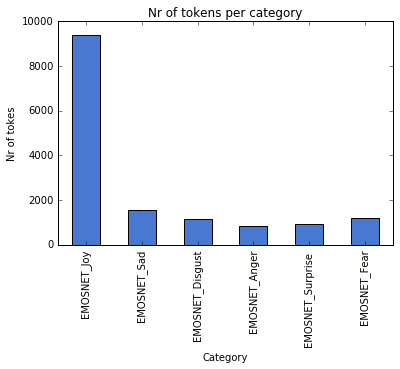

In [28]:
a = r.emosnet.df.sum().plot(kind='bar')
a.set_title('Nr of tokens per category')
a.set_ylabel('Nr of tokes')
_ = a.set_xlabel('Category')

In [74]:
# use all tokens
emosnet_params = dict(return_tokens=True, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True, bigrams=False, trigrams=False)

# test full features
emosnet_comp = compare_percentiles(r.emosnet, **emosnet_params)
emosnet_comp

Final shape (8171, 695) (1405, 695)
train data, lex and final shape:  (8171, 927) (8171, 695) (8171, 1622)
test data, lex and final shape:  (1405, 927) (1405, 695) (1405, 1622)
Final shape (8171, 1391) (1405, 1391)
train data, lex and final shape:  (8171, 927) (8171, 1391) (8171, 2318)
test data, lex and final shape:  (1405, 927) (1405, 1391) (1405, 2318)
Final shape (8171, 2087) (1405, 2087)
train data, lex and final shape:  (8171, 927) (8171, 2087) (8171, 3014)
test data, lex and final shape:  (1405, 927) (1405, 2087) (1405, 3014)
Final shape (8171, 4174) (1405, 4174)
train data, lex and final shape:  (8171, 927) (8171, 4174) (8171, 5101)
test data, lex and final shape:  (1405, 927) (1405, 4174) (1405, 5101)
Final shape (8171, 13914) (1405, 13914)
train data, lex and final shape:  (8171, 927) (8171, 13914) (8171, 14841)
test data, lex and final shape:  (1405, 927) (1405, 13914) (1405, 14841)


In [64]:
# use all tokens
emosnet_params = dict(return_tokens=False, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True, bigrams=False, trigrams=False)
# test full features
scores, train_sent, test_sent = process_emo_pipeline(r.emosnet, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels,
                     **emosnet_params)
pipe.pprint_results(scores)

train data, lex and final shape:  (8171, 927) (8171, 30) (8171, 957)
test data, lex and final shape:  (1405, 927) (1405, 30) (1405, 957)


In [31]:
test_individual_scales(r.emosnet, **emosnet_params)

[u'Joy', u'Sad', u'Disgust', u'Anger', u'Surprise ', u'Fear']
Joy
[{u'Joy_avg': 0.5, u'Joy_minn': 0, u'Joy_summ': 1, u'Joy_maxn': 1, u'Joy_count': 2}, {u'Joy_avg': 0.66666666666666663, u'Joy_minn': 0, u'Joy_summ': 4, u'Joy_maxn': 1, u'Joy_count': 6}, {u'Joy_avg': 0.5, u'Joy_minn': 0, u'Joy_summ': 3, u'Joy_maxn': 1, u'Joy_count': 6}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8027.0, 8171, 1385.0, 1405)
Coverage train: 98.24%, test: 98.24%
train data, lex and final shape:  (8171, 927) (8171, 5) (8171, 932)
test data, lex and final shape:  (1405, 927) (1405, 5) (1405, 932)


Sad
[{u'Sad_summ': 0, u'Sad_avg': 0.0, u'Sad_maxn': 0, u'Sad_minn': 0, u'Sad_count': 2}, {u'Sad_summ': 1, u'Sad_avg': 0.16666666666666666, u'Sad_maxn': 1, u'Sad_minn': 0, u'Sad_count': 6}, {u'Sad_summ': 3, u'Sad_avg': 0.5, u'Sad_maxn': 1, u'Sad_minn': 0, u'Sad_count': 6}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8027.0, 8171, 1385.0, 1405)
Coverage train: 98.24%, test: 98.24%
train data, lex and final shape:  (8171, 927) (8171, 5) (8171, 932)
test data, lex and final shape:  (1405, 927) (1405, 5) (1405, 932)


Disgust
[{u'Disgust_maxn': 0, u'Disgust_minn': 0, u'Disgust_count': 2, u'Disgust_summ': 0, u'Disgust_avg': 0.0}, {u'Disgust_maxn': 1, u'Disgust_minn': 0, u'Disgust_count': 6, u'Disgust_summ': 1, u'Disgust_avg': 0.16666666666666666}, {u'Disgust_maxn': 0, u'Disgust_minn': 0, u'Disgust_count': 6, u'Disgust_summ': 0, u'Disgust_avg': 0.0}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8027.0, 8171, 1385.0, 1405)
Coverage train: 98.24%, test: 98.24%
train data, lex and final shape:  (8171, 927) (8171, 5) (8171, 932)
test data, lex and final shape:  (1405, 927) (1405, 5) (1405, 932)


Anger
[{u'Anger_minn': 0, u'Anger_avg': 0.5, u'Anger_maxn': 1, u'Anger_summ': 1, u'Anger_count': 2}, {u'Anger_minn': 0, u'Anger_avg': 0.0, u'Anger_maxn': 0, u'Anger_summ': 0, u'Anger_count': 6}, {u'Anger_minn': 0, u'Anger_avg': 0.0, u'Anger_maxn': 0, u'Anger_summ': 0, u'Anger_count': 6}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8027.0, 8171, 1385.0, 1405)
Coverage train: 98.24%, test: 98.24%
train data, lex and final shape:  (8171, 927) (8171, 5) (8171, 932)
test data, lex and final shape:  (1405, 927) (1405, 5) (1405, 932)


Surprise 
[{u'Surprise _count': 2, u'Surprise _maxn': 0, u'Surprise _minn': 0, u'Surprise _summ': 0, u'Surprise _avg': 0.0}, {u'Surprise _count': 6, u'Surprise _maxn': 0, u'Surprise _minn': 0, u'Surprise _summ': 0, u'Surprise _avg': 0.0}, {u'Surprise _count': 6, u'Surprise _maxn': 0, u'Surprise _minn': 0, u'Surprise _summ': 0, u'Surprise _avg': 0.0}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8027.0, 8171, 1385.0, 1405)
Coverage train: 98.24%, test: 98.24%
train data, lex and final shape:  (8171, 927) (8171, 5) (8171, 932)
test data, lex and final shape:  (1405, 927) (1405, 5) (1405, 932)


Fear
[{u'Fear_maxn': 0, u'Fear_count': 2, u'Fear_avg': 0.0, u'Fear_minn': 0, u'Fear_summ': 0}, {u'Fear_maxn': 0, u'Fear_count': 6, u'Fear_avg': 0.0, u'Fear_minn': 0, u'Fear_summ': 0}, {u'Fear_maxn': 0, u'Fear_count': 6, u'Fear_avg': 0.0, u'Fear_minn': 0, u'Fear_summ': 0}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8027.0, 8171, 1385.0, 1405)
Coverage train: 98.24%, test: 98.24%
train data, lex and final shape:  (8171, 927) (8171, 5) (8171, 932)
test data, lex and final shape:  (1405, 927) (1405, 5) (1405, 932)


### Best Model EmosSenticNet

In [32]:
# use all tokens
emosnet_params = dict(return_tokens=False, return_avg=True, 
              return_sum=True, return_min=True, return_max=True,
              return_pol_amt=True)
# test full features
scores, train_sent, test_sent = process_emo_pipeline(r.emosnet, train_tokens, dev_tokens, 
                     train_data, labels, dev_data, dev_labels, filter_tags=['Disgust','Joy'], verbose=True,
                     **emosnet_params)
pipe.pprint_results(scores)

[{u'Disgust_maxn': 0, u'Joy_summ': 1, u'Disgust_count': 2, u'Disgust_avg': 0.0, u'Disgust_minn': 0, u'Joy_maxn': 1, u'Joy_count': 2, u'Joy_avg': 0.5, u'Joy_minn': 0, u'Disgust_summ': 0}, {u'Disgust_maxn': 1, u'Joy_summ': 4, u'Disgust_count': 6, u'Disgust_avg': 0.16666666666666666, u'Disgust_minn': 0, u'Joy_maxn': 1, u'Joy_count': 6, u'Joy_avg': 0.66666666666666663, u'Joy_minn': 0, u'Disgust_summ': 1}, {u'Disgust_maxn': 0, u'Joy_summ': 3, u'Disgust_count': 6, u'Disgust_avg': 0.0, u'Disgust_minn': 0, u'Joy_maxn': 1, u'Joy_count': 6, u'Joy_avg': 0.5, u'Joy_minn': 0, u'Disgust_summ': 0}]
('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8027.0, 8171, 1385.0, 1405)
Coverage train: 98.24%, test: 98.24%
train data, lex and final shape:  (8171, 927) (8171, 10) (8171, 937)
test data, lex and final shape:  (1405, 927) (1405, 10) (1405, 937)


### LIWC

LIWC is a payed solution so we apply the processing pipeline directly on the tweets

In [85]:
import pandas as pd
train_liwc = fh.read_liwc('../2-Processed/allTrainingData.liwc.tsv')
train_liwc1 = fh.read_liwc('../2-Processed/trainingData-B.liwc.tsv')
dev_liwc = fh.read_liwc('../2-Processed/devData-B.liwc.tsv')
test_liwc = fh.read_liwc('../2-Processed/testData-B.liwc.tsv')

In [79]:
len(test_liwc)

3810

In [34]:
tmp = pd.DataFrame(train_liwc).T
tmp.head()

,ABBREVIATIONS,ACHIEVEMENT,AFFECTIVE_PROCESS,ALLPCT,ANGER,ANXIETY,APOSTRO,ARTICLES,ASSENTS,BODY_STATES,...,SWEAR_WORDS,TENTATIVE,TIME,TV_OR_MOVIE,UNIQUE,UP,WC,WE,WPS,YOU
90832477970636801,0.0,0.000000,0.000000,31.818182,0.000000,0.0,9.090909,4.545455,0.0,0.0,...,0.0,0.000000,4.545455,0.0,90.909091,0.000000,22.0,0.000000,11.0,0.0
90835879622488064,0.0,4.545455,4.545455,13.636364,0.000000,0.0,0.000000,4.545455,0.0,0.0,...,0.0,0.000000,13.636364,0.0,95.454545,4.545455,22.0,0.000000,11.0,0.0
90854967476363265,0.0,0.000000,4.761905,52.380952,4.761905,0.0,0.000000,0.000000,0.0,0.0,...,0.0,4.761905,4.761905,0.0,90.476190,0.000000,21.0,0.000000,10.5,0.0
90905261992194048,0.0,0.000000,0.000000,21.428571,0.000000,0.0,0.000000,7.142857,0.0,0.0,...,0.0,0.000000,21.428571,0.0,100.000000,7.142857,14.0,7.142857,14.0,0.0
90965889557594112,0.0,0.000000,0.000000,5.000000,0.000000,0.0,5.000000,5.000000,0.0,0.0,...,0.0,0.000000,5.000000,0.0,90.000000,0.000000,20.0,0.000000,20.0,0.0


In [35]:
tmp[[u'POSITIVE_FEELING', u'POSITIVE_EMOTION', u'NEGATIVE_EMOTION']]

,POSITIVE_FEELING,POSITIVE_EMOTION,NEGATIVE_EMOTION
90832477970636801,0.000000,0.000000,0.000000
90835879622488064,0.000000,4.545455,0.000000
90854967476363265,0.000000,0.000000,4.761905
90905261992194048,0.000000,0.000000,0.000000
90965889557594112,0.000000,0.000000,0.000000
90969859780919296,0.000000,0.000000,0.000000
90971482913652736,0.000000,7.407407,0.000000
90984113938509824,0.000000,8.000000,4.000000
91030346635808768,0.000000,9.090909,9.090909
91081325884358656,0.000000,7.142857,0.000000


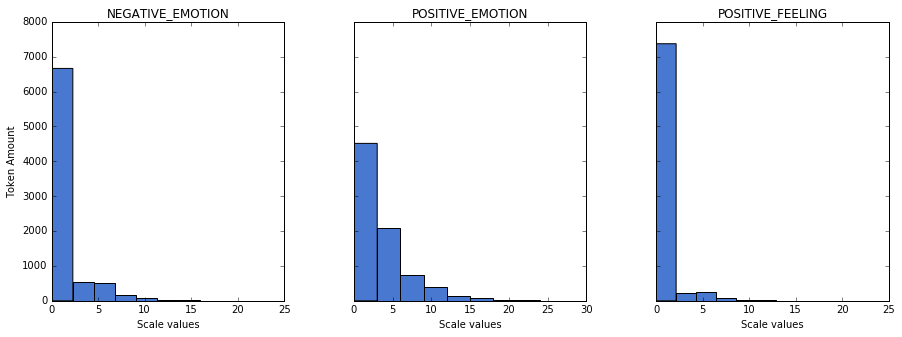

In [36]:
f, axs = plt.subplots(1,3, figsize=(15, 5), sharey=True)
a = tmp[[u'POSITIVE_FEELING', u'POSITIVE_EMOTION', u'NEGATIVE_EMOTION']].hist(grid=False,ax=axs)
axs[0].set_ylabel('Token Amount')
for ax in axs: 
    ax.set_xlabel('Scale values')

In [37]:
zero = {'ABBREVIATIONS': 0.0, 'ACHIEVEMENT': 0.0, 'AFFECTIVE_PROCESS': 0.0, 'ALLPCT': 0.0, 'ANGER': 0.0, 'ANXIETY': 0.0, 'APOSTRO': 0.0, 'ARTICLES': 0.0, 'ASSENTS': 0.0, 'BODY_STATES': 0.0, 'CAUSATION': 0.0, 'CERTAINTY': 0.0, 'COGNITIVE_PROCESS': 0.0, 'COLON': 0.0, 'COMMA': 0.0, 'COMMUNICATION': 0.0, 'DASH': 0.0, 'DEATH_AND_DYING': 0.0, 'DIC': 0.0, 'DISCREPANCY': 0.0, 'DOWN': 0.0, 'EATING': 0.0, 'EMOTICONS': 0.0, 'EXCLAM': 0.0, 'EXCLUSIVE': 0.0, 'FAMILY': 0.0, 'FEELING': 0.0, 'FILLERS': 0.0, 'FRIENDS': 0.0, 'FUTURE': 0.0, 'GROOMING': 0.0, 'HEARING': 0.0, 'HOME': 0.0, 'HUMANS': 0.0, 'I': 0.0, 'INCLUSIVE': 0.0, 'INHIBITION': 0.0, 'INSIGHT': 0.0, 'JOB_OR_WORK': 0.0, 'LEISURE_ACTIVITY': 0.0, 'METAPHYSICAL': 0.0, 'MONEY': 0.0, 'MOTION': 0.0, 'MUSIC': 0.0, 'NEGATIONS': 0.0, 'NEGATIVE_EMOTION': 0.0, 'NONFLUENCIES': 0.0, 'NUMBERS': 0.0, 'OCCUPATION': 0.0, 'OPTIMISM': 0.0, 'OTHER': 0.0, 'OTHERP': 0.0, 'PARENTH': 0.0, 'PAST': 0.0, 'PERIOD': 0.0, 'PHYSICAL_STATES': 0.0, 'POSITIVE_EMOTION': 0.0, 'POSITIVE_FEELING': 0.0, 'PREPOSITIONS': 0.0, 'PRESENT': 0.0, 'PRONOUN': 0.0, 'QMARK': 0.0, 'QMARKS': 0.0, 'QUOTE': 0.0, 'REFERENCE_PEOPLE': 0.0, 'RELIGION': 0.0, 'SADNESS': 0.0, 'SCHOOL': 0.0, 'SEEING': 0.0, 'SELF': 0.0, 'SEMIC': 0.0, 'SENSORY_PROCESS': 0.0, 'SEXUALITY': 0.0, 'SIXLTR': 0.0, 'SLEEPING': 0.0, 'SOCIAL_PROCESS': 0.0, 'SPACE': 0.0, 'SPORTS': 0.0, 'SWEAR_WORDS': 0.0, 'TENTATIVE': 0.0, 'TIME': 0.0, 'TV_OR_MOVIE': 0.0, 'UNIQUE': 0.0, 'UP': 0.0, 'WC': 0.0, 'WE': 0.0, 'WPS': 0.0, 'YOU': 0.0}

In [83]:
# as all the information comes out of orde from liwc, it needs to be put in order again.
train_sent_liwc = [ train_liwc.get(int(tw.sid), train_liwc1.get(int(tw.sid), zero)) for tw in train_feat]
dev_sent_liwc = [ dev_liwc[int(tw.sid)] for tw in dev_feat]
train_sent_liwc = [ test_liwc[int(tw.sid)] for tw in test_feat]

In [39]:
X_liwc,X_dev_liwc = pipe.join_lex_features(train_data, train_sent_liwc,
                                            dev_data, dev_sent_liwc)

train data, lex and final shape:  (8171, 927) (8171, 88) (8171, 1015)
test data, lex and final shape:  (1405, 927) (1405, 88) (1405, 1015)


In [45]:
# it is an vector. For each tweet sum the number of tokens found
train_tmp = X_liwc.todense()
dev_tmp = X_dev_liwc.todense()
num_tw_found_train = float(np.array([ 1 for t in train_tmp if t.sum()]).sum())
num_tw_found_dev = float(np.array([ 1 for t in dev_tmp if t.sum()]).sum())

len_train = train_data.shape[0]
len_dev = dev_data.shape[0]
per_train = num_tw_found_train/len_train
per_dev = num_tw_found_dev/len_dev
print('num_tw_found_train, len_train, num_tw_found_dev, len_dev',num_tw_found_train, len_train, num_tw_found_dev, len_dev)
print('Coverage train: {0:.2%}, test: {0:.2%}'.format(per_train, per_dev))

('num_tw_found_train, len_train, num_tw_found_dev, len_dev', 8170.0, 8171, 1405.0, 1405)
Coverage train: 99.99%, test: 99.99%


### Best Model LIWC

In [40]:
# adding LWC into the base
ret_liwc = pipe.run_multiple_class(X_liwc, labels, X_dev_liwc, dev_labels, rnd_seed=rnd_seed, scale=False)
pipe.pprint_results(ret_liwc)

In [41]:
# using liwc only
X_liwc_only,X_dev_liwc_only, _, _ = pipe.create_lex_vec(train_sent_liwc, dev_sent_liwc)
ret_liwc_only = pipe.run_multiple_class(X_liwc_only, labels, X_dev_liwc_only, dev_labels, rnd_seed=rnd_seed, scale=False)
pipe.pprint_results(ret_liwc_only)

In [42]:
def process_liwc_selection(percent):

    train_sent, dev_sent, _ = pipe.auto_select_features(pipe.mutual_info_classif, percent, 
                                                        X_liwc_only, labels, 
                                                        X_dev_liwc_only, dev_labels)

    # create training and dev datasets
    X ,X_dev = pipe.join_lex_features(train_data, train_sent,
                                      dev_data, dev_sent,
                                      create_vec=False)


    # train the algorithms
    scores = pipe.run_multiple_class(X, labels, X_dev, dev_labels, rnd_seed=rnd_seed, use_best_params=True)
    return scores, train_sent, dev_sent  
    
def test_percentile(percentile, test_name, negate=False, **features):
    tmp,_,_ = process_lew_selection(percentile)
    tmp = tmp[['train score', 'dev score']]
    return tmp.add_prefix(str(percentile)+' ')

    
def compare_percentiles_liwc(percentiles = [5,10,15,30, 100], test_name='dev', negate=False, **features):
    
    def highlight_max(s):
        '''
        highlight the maximum in a Series in bold.
        '''
        is_max = s == s.max()
        css = ['font-weight: bold' if v else '' for v in is_max]
        return css
    
    def highlight_top3(s):
        '''
        highlight the top3 in a Series in bold.
        '''
        # colors for the background an create an ordered vector
        shades = [200, 220, 247]
        ordered = s.sort_values(ascending=False)
        ordered.reset_index(inplace=True, drop=True)
        idx = pd.Index(ordered)
        
        # paint the Background accordingly
        css = ['background-color: rgb({color},{color},{color})'\
               .format(color=shades[idx.get_loc(v)]) \
               if idx.get_loc(v)<3 else '' for v in s]
        return css

    
    # get a first df
    df = test_percentile(percentiles[0], test_name, negate=negate, **features)
    for perc in percentiles[1:]:
        tmp = test_percentile(perc, test_name, negate=negate, **features)
        df = pd.concat([df, tmp], axis = 1)

    return df.style.apply(highlight_max).apply(highlight_top3)

compare_percentiles_liwc()

Final shape (8171, 5) (1405, 5)
train data, lex and final shape:  (8171, 927) (8171, 5) (8171, 932)
test data, lex and final shape:  (1405, 927) (1405, 5) (1405, 932)
Final shape (8171, 9) (1405, 9)
train data, lex and final shape:  (8171, 927) (8171, 9) (8171, 936)
test data, lex and final shape:  (1405, 927) (1405, 9) (1405, 936)
Final shape (8171, 14) (1405, 14)
train data, lex and final shape:  (8171, 927) (8171, 14) (8171, 941)
test data, lex and final shape:  (1405, 927) (1405, 14) (1405, 941)
Final shape (8171, 27) (1405, 27)
train data, lex and final shape:  (8171, 927) (8171, 27) (8171, 954)
test data, lex and final shape:  (1405, 927) (1405, 27) (1405, 954)
Final shape (8171, 88) (1405, 88)
train data, lex and final shape:  (8171, 927) (8171, 88) (8171, 1015)
test data, lex and final shape:  (1405, 927) (1405, 88) (1405, 1015)


LIWC as a more elaborated approach gave a better result